<a href="https://colab.research.google.com/github/Nargiz-chess/Solar_power_forecasting/blob/main/ConvLSTM_5_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

from pandas import read_csv
import pandas as pd
import datetime as dt
import matplotlib
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import csv
import tensorflow as tf
import keras
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from tensorflow.keras import optimizers
from keras.callbacks import TerminateOnNaN


path1 = '/content/drive/MyDrive/Master_thesis/Datasets/Australia_numpy_removed_night_hours.npy'
path2 = '/content/drive/MyDrive/Master_thesis/Datasets/irradiance_AUS(2012-2013).csv'

Mounted at /content/drive


In [ ]:
n_house = 100
valid_house = 20 
test_house = 20  #for final predictions 

In [ ]:
import random
np.random.seed(42)

houses = np.loadtxt(path1)
shuffle = np.arange(houses.shape[1])
np.random.shuffle(shuffle)
houses = houses[:,shuffle]
irraidance=read_csv(path2, header =0, index_col=0) 
irraidance=irraidance.drop("time", axis=1)
irradiance_array= irraidance.values
weath_data = irradiance_array.reshape(irradiance_array.shape[0]*irradiance_array.shape[1])
train_val_set = houses[:,:n_house+valid_house]
train_val_set = train_val_set.reshape(train_val_set.shape[0]*train_val_set.shape[1], order="F")
weath_data_stacked = np.tile(weath_data,n_house+valid_house)
data2 = pd.DataFrame(np.column_stack((train_val_set,weath_data_stacked)))
test_set = houses[:,-20:] #don't stack. Keep aside for final predictions and loop house by house (add weath_data in each loop)


In [ ]:
# # split a multivariate dataset into train/test sets
def split_dataset(data,test_houses):
	# split into standard weeks
 train, test = data[0:-365*18*test_houses], data[-365*18*test_houses:]
	# restructure into windows of weekly data
 train = array(split(train, len(train)/18))
 test = array(split(test, len(test)/18))
 print(train.shape,test.shape)
 return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=18):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, test_X, test_y, epochs,  batch_size, n_steps, n_length, n_input ):
 # prepare data
 train_x, train_y = to_supervised(train, n_input)
 # define parameters
 n_features, n_outputs = train_x.shape[2], train_y.shape[1]
 # reshape into subsequences [samples, timesteps, rows, cols, channels]
 train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
 # reshape output into [samples, timesteps, features]
 train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

 # reshape valiation X set into subsequences [samples, timesteps, rows, cols, channels]
 test_X = test_X.reshape((test_X.shape[0], n_steps, 1, n_length, n_features))
 # reshape validation y into [samples, timesteps, features]
 test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

 # stop when loss remains the same for 3 epochs --> passed to the model.fit
 early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
 #saves the model on drive.
 path = '/content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B32_HL50_house_'+str(n_house)+'_input_'+str(n_input)+'.h5'
 model_checkpoint = ModelCheckpoint(path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
 #stop training when loss gets to Nan
 call = keras.callbacks.TerminateOnNaN()
 # define model
 model = Sequential()
 model.add(ConvLSTM2D(filters=20, kernel_size=(1,3), activation='relu',input_shape=(n_steps, 1, n_length, n_features)))
 model.add(Flatten())
 model.add(RepeatVector(n_outputs))
 model.add(LSTM(50, activation='relu', return_sequences=True))
 #model.add(LSTM(20, activation='relu', return_sequences=True))
 model.add(TimeDistributed(Dense(100, activation='relu')))
 model.add(TimeDistributed(Dense(1)))
 model.compile(loss='mse', optimizer='adam')
 # fit network
 history_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping,model_checkpoint,call],validation_data = (test_X,test_y)) #removed val_loss
 #history_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping,model_checkpoint,call])
# path2 = '/content/drive/MyDrive/Master_thesis/Models/ConvLSTM/Loss_Val_loss_house_'+str(n_house)+'_input_'+str(n_input)+'.h5'
#  with open(path2+'.csv','a') as nd:
#      write_n = csv.writer(nd)
#      write_n.writerow([history_model.history['loss'],history_model.history['val_loss']])
 return model,history_model.history
 
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [samples, timesteps, rows, cols, channels]
  input_x = input_x.reshape((1, n_steps, 1, n_length, 2))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat


# define the number of subsequences and the length of subsequences
n_steps, n_length = 5, 18
# define the total days to use as input
n_input = n_length * n_steps
#define parameters for the model
epochs, batch_size = 30,32
#data preparation
data= data2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data) 
train,test = split_dataset(data,valid_house)
train_scaled, test_scaled = split_dataset(scaled,valid_house)
test_X,test_y = to_supervised(test_scaled,n_input)


# evaluate model and get scores
model,history_model = build_model(train_scaled, test_X, test_y, epochs, batch_size, n_steps, n_length, n_input)

history = [x for x in train_scaled]
predictions = list()

for i in range(len(test)):
  yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
  #inverse scaling manually 
  test_min = np.min(data[-365*18*valid_house:,0])
  test_max = np.max(data[-365*18*valid_house:,0])
  yhat_sequence = yhat_sequence * (test_max-test_min)
  predictions.append(yhat_sequence)
  #add actual observations for next forecasting
  history.append(test_scaled[i, :])
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

# summarize scores
summarize_scores('ConvLSTM', score, scores)
# plot scores
hours = ['1', '2', '3', '4', '5', '6', '7','8','9','10','11','12','13','14','15','16','17','18']
pyplot.plot(hours, scores, marker='o', label='ConvLSTM')
pyplot.show()

# plot history
# pyplot.plot(history_model['loss'], label='train')
# pyplot.plot(history_model['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

#Predictions based on unseen test set 

#Forecasting with a daily moving window

In [ ]:
def forecast_daily(model, test,weather,input_length,n_steps,n_length):
  all = list()
  for house in range(test.shape[1]):
    predictions = list()
    #iterating over houses and taking each house seperately
    data = test[:,house]
    #finding min and max values each house seperately
    house_max = np.max(data)
    house_min = np.min(data)
    #combining house with weather data
    data = np.column_stack((data,weather))
    #scale
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    for hour in range(0,data.shape[0],18):
      #looping thourough each house - moving window
      input = data[hour:hour+input_length,:]
      if input.shape[0]*input.shape[1] < 2* input_length:
        break
      input = input.reshape((1, n_steps, 1, n_length, 2))
      y_hat = model.predict(input)
      y_hat = np.array(y_hat).flatten()
      #inverse scaling
      y_hat = y_hat * (house_max-house_min)
      predictions.append(y_hat)
      #save predictions
    with open('/content/drive/MyDrive/Master_thesis/Results/ConvLSTM/Results_copy_models/Copy of E30_B32_HL50_house_'+str(house)+'_input_'+str(n_input)+'.csv','a') as nd:
      write_n = csv.writer(nd)
      write_n.writerows(predictions)
    all.append(predictions)
  return np.array(all).shape

# define the number of subsequences and the length of subsequences
n_steps, n_length = 5, 18
# define the total days to use as input
n_input = n_length * n_steps

model = keras.models.load_model('/content/drive/MyDrive/Master_thesis/Models/ConvLSTM/Copy of E30_B32_HL50_house_'+str(n_house)+'_input_'+str(n_input)+'.h5')
forecast_daily(model,test_set,weath_data,n_input,n_steps,n_length)

(20, 361, 18)

In [ ]:
### EVALUATION ### 

print("Shape of the test set = ", test_set.shape)
print("Shape of the weather set = ", weath_data.shape)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 5, 18
# define the total days to use as input
n_input = n_length * n_steps
# substract hours with input length from the beginning of the data
data = test_set[n_input:,:]
from statistics import mean

RMSEs = list()
MAEs=list()


for house in range(data.shape[1]):
  actual_house = data[:,house]
  path ='/content/drive/MyDrive/Master_thesis/Results/ConvLSTM/Results_copy_models/Copy of E30_B32_HL50_house_'+str(house)+'_input_'+str(n_input)+'.csv'
  pred_house = read_csv(path,header=None)[:-1]
  pred_house = np.array(pred_house)
  #print(actual_house.shape,pred_house.shape)
  
  row_pred = 0
  for hours in range(0,data.shape[0]-n_input,18):
  #for hours in range(1):
    actual =  actual_house[hours: 18+hours]
    pred = pred_house[row_pred,:]
 
    rmse = sqrt(mean_squared_error(actual,pred))
    RMSEs.append(rmse)
    mae= mean_absolute_error(actual,pred) 
    MAEs.append(mae)
    row_pred+=1

print("RMSE",mean(RMSEs),"Shape of RMSEs = ", np.array(RMSEs).shape)
print("MAE",mean(MAEs),"Shape of MAEs = ", np.array(MAEs).shape)



#Epochs 30 , val loss , batch size 48

(36500, 18, 2) (7300, 18, 2)
(36500, 18, 2) (7300, 18, 2)
Epoch 1/30
13685/13686 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00001: val_loss improved from inf to 0.00189, saving model to /content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B48_house_100_input_90.h5
13686/13686 [==============================] - 424s 31ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 2/30
13685/13686 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00002: val_loss improved from 0.00189 to 0.00174, saving model to /content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B48_house_100_input_90.h5
13686/13686 [==============================] - 416s 30ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/30
13685/13686 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00003: val_loss improved from 0.00174 to 0.00171, saving model to /content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B48_house_100_input_90.h5
13686/13686 [==============================] -

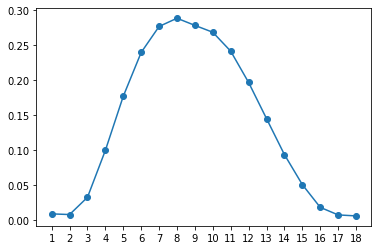

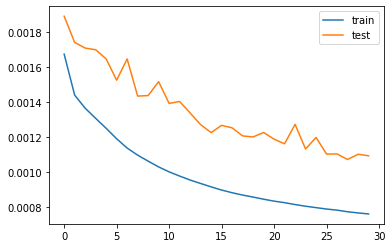

In [ ]:
# # split a univariate dataset into train/test sets
def split_dataset(data,test_houses):
	# split into standard weeks
 train, test = data[0:-365*18*test_houses], data[-365*18*test_houses:]
	# restructure into windows of weekly data
 train = array(split(train, len(train)/18))
 test = array(split(test, len(test)/18))
 print(train.shape,test.shape)
 return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=18):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, test_X, test_y, epochs,  batch_size, n_steps, n_length, n_input ):
 # prepare data
 train_x, train_y = to_supervised(train, n_input)
 # define parameters
 n_features, n_outputs = train_x.shape[2], train_y.shape[1]
 # reshape into subsequences [samples, timesteps, rows, cols, channels]
 train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
 # reshape output into [samples, timesteps, features]
 train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  
  # reshape valiation X set into subsequences [samples, timesteps, rows, cols, channels]
 test_X = test_X.reshape((test_X.shape[0], n_steps, 1, n_length, n_features))
 # reshape validation y into [samples, timesteps, features]
 test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

 # stop when loss remains the same for 3 epochs --> passed to the model.fit
 early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
 #saves the model on drive.
 path = '/content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B48_house_'+str(n_house)+'_input_'+str(n_input)+'.h5' #change this in every change in the model parameters! 
 model_checkpoint = ModelCheckpoint(path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, patience = 5)
 #stop training when loss gets to Nan
 call = keras.callbacks.TerminateOnNaN()
 # define model
 model = Sequential()
 model.add(ConvLSTM2D(filters=20, kernel_size=(1,3), activation='relu',input_shape=(n_steps, 1, n_length, n_features)))
 model.add(Flatten())
 model.add(RepeatVector(n_outputs))
 model.add(LSTM(20, activation='relu', return_sequences=True))
 #model.add(LSTM(20, activation='relu', return_sequences=True))
 model.add(TimeDistributed(Dense(100, activation='relu')))
 model.add(TimeDistributed(Dense(1)))
 model.compile(loss='mse', optimizer='adam')
 # fit network
 history_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping,model_checkpoint,call],validation_data = (test_X,test_y)) #removed val_loss
 path2 = '/content/drive/MyDrive/Master_thesis/Models/ConvLSTM/E30_B48_Loss_Val_loss_house_'+str(n_house)+'_input_'+str(n_input)
#  with open(path2+'.csv','a') as nd:
#      write_n = csv.writer(nd)
#      write_n.writerow([history_model.history['loss'],history_model.history['val_loss']])
 return model,history_model.history
 
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [samples, timesteps, rows, cols, channels]
  input_x = input_x.reshape((1, n_steps, 1, n_length, 2))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat


# define the number of subsequences and the length of subsequences
n_steps, n_length = 5, 18
# define the total days to use as input
n_input = n_length * n_steps
#define parameters for the model
epochs, batch_size = 30,48
#data preparation
data= data2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data) 
train,test = split_dataset(data,valid_house)
train_scaled, test_scaled = split_dataset(scaled,valid_house)
test_X,test_y = to_supervised(test_scaled,n_input)


# evaluate model and get scores
model,history_model = build_model(train_scaled, test_X, test_y, epochs, batch_size, n_steps, n_length, n_input)

history = [x for x in train_scaled]
predictions = list()

for i in range(len(test)):
  yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
  #inverse scaling manually 
  test_min = np.min(data[-365*18*valid_house:,0])
  test_max = np.max(data[-365*18*valid_house:,0])
  yhat_sequence = yhat_sequence * (test_max-test_min)
  predictions.append(yhat_sequence)
  #add actual observations for next forecasting
  history.append(test_scaled[i, :])
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

# summarize scores
summarize_scores('ConvLSTM', score, scores)
# plot scores
hours = ['1', '2', '3', '4', '5', '6', '7','8','9','10','11','12','13','14','15','16','17','18']
pyplot.plot(hours, scores, marker='o', label='ConvLSTM')
pyplot.show()

#plot history
pyplot.plot(history_model['loss'], label='train')
pyplot.plot(history_model['val_loss'], label='test')
pyplot.legend()
pyplot.show()